# Creating a web-ready model

There are a few goals here:
    
- MVP
    - Type in a known song in the database, return the 5 most likely producers and their percentages.
    - Display the 5 most similar songs
- Nice to Have
    - All above plus
    - Ability to type in any song with spotify mp3
- Better
    - All the above plus
    - New song -> Display producer for that song.
- Best
    - All the above plus
    - Model updates on the fly based on others' input

# MVP

### Recreate the model:

In [1]:
# Standard Imports
from __future__ import print_function
import numpy as np
import pandas as pd
import os
import sys
from collections import defaultdict
from importlib import reload
from bs4 import BeautifulSoup
import requests
import scipy.stats as scs
import time
import seaborn as sns

import matplotlib.pyplot as plt

# Modeling
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import datasets, layers, models
# import keras.backend as K
# from tensorflow.keras.constraints import min_max_norm, non_neg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

# Load MongoDB
from pymongo import MongoClient
client = MongoClient()
# Access/Initiate Database
db = client['producer_db']
# Access/Initiate Table
mfcc_tab = db['mfcc']
tab = db['songs']
collection = db.tab
mfcc_collection = db.mfcc_tab

# Authorize Spotify API
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_id = os.environ['SPOTIFY_CLIENT_ID']
client_secret = os.environ['SPOTIFY_CLIENT_SECRET']
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [2]:
# Create a Pandas DataFrame of the Data
song_data_list = []
audio_feature = 'mfcc_highpass'
for song in mfcc_collection.find():
    try:
        song_data = (song['track'],song['artist'],song['album'],song[audio_feature],song['basic_genre'],song['producer'])
        song_data_list.append(song_data)
    except:
        pass
song_df = pd.DataFrame(song_data_list, columns = ['track','artist','album',audio_feature,'genre','producer'])
song_df = song_df[song_df[audio_feature].apply(lambda x: np.array(x).shape[1]) >= 1200] #ensures all audio features are same size.

# Make feature matrix
X = np.vstack(song_df[audio_feature].apply(lambda x: np.array(x)[:,:1200].flatten()).values)

# Make target vector, one-hot encoded vector, and y_columns - a "legend" for the vectors.
y = song_df['producer']
y_one_hot = pd.get_dummies(y).values
y_columns = np.array(pd.get_dummies(y).columns)

# Test train split.
X_train, X_test, y_train, y_test = train_test_split(X ,y_one_hot, test_size = 0.3, random_state = 440)

# Standardize
ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train)
X_test_scale = ss.transform(X_test)


# Use PCA to reduce dimensionality
pca = PCA(n_components=12)
X_train_pca = pca.fit_transform(X_train_scale)
X_test_pca = pca.transform(X_test_scale)

# Make a knn model
knn = KNeighborsClassifier(n_neighbors = 30)
knn.fit(X_train_pca, y_train)

# Convert y labels from unit vectors to integers
y_test_labels = np.argmax(y_test, axis = 1)
y_hat = knn.predict(X_test_pca)
y_hat_labels = np.argmax(np.stack(knn.predict_proba(X_test_pca))[:,:,1].T, axis = 1)


# Calculate Metrics
accuracy = (y_test_labels == y_hat_labels).sum()/y_test_labels.size
maj_class = np.argmax(y_train.sum(axis = 0))
benchmark = (y_test_labels == maj_class).sum()/y_test_labels.size # Benchmark is guessing majority class

# Print Metric
print("Producer Accuracy:\t{:.2f}".format(accuracy))
print("Benchmark:\t\t{:.2f}".format(benchmark)) 
print()


Producer Accuracy:	0.43
Benchmark:		0.08



In [96]:
distances, indices = knn.kneighbors(X_test_pca[0:1,:1200])

In [97]:
is_neighbor = knn.kneighbors_graph(X_test_pca[0:1,:1200], n_neighbors = 5)

In [98]:
my_df = pd.DataFrame([(1,2,3),(4,5,6),(1,2,3),(4,5,6),(1,2,3),(4,5,6),(1,2,3),(4,5,6)],columns=['A','B','C'])

In [99]:
top_producers = np.argsort(np.vstack(knn.predict_proba(X_test_pca[0:1,:1200]))[:,1])[::-1]

In [100]:
test_array = np.random.rand(3,4)
test_array

array([[0.14084063, 0.52480538, 0.10881116, 0.54927421],
       [0.28411038, 0.73124733, 0.3609393 , 0.07743544],
       [0.67944859, 0.94568109, 0.00622502, 0.58103205]])

In [101]:
np.argsort(test_array, axis = 1)

array([[2, 0, 1, 3],
       [3, 0, 2, 1],
       [2, 3, 0, 1]])

In [102]:
song_df.head()

,track,artist,album,mfcc_highpass,genre,producer
0,Act Naturally,Buck Owens and the Buckaroos,The Best of Buck Owens,"[[-106.0409148180113, -114.71286150048788, -15...",country,George Martin
1,Alfie,Cilla Black,Cilla Black singles chronology,"[[-115.42859278964515, -133.7129072512278, -20...",pop,George Martin
2,Amber Cascades,America,Hideaway,"[[-132.7895650459967, -149.0103345463059, -205...",country,George Martin
3,Anyone Who Had a Heart,Dionne Warwick,Anyone Who Had a Heart,"[[-417.5704948136371, -400.7918664259179, -375...",soul,George Martin
4,Baby It's You,The Shirelles,Baby It's You,"[[-199.51104878028514, -215.14526944983157, -2...",soul,George Martin


In [71]:
X_scale = ss.transform(X)
X_pca = pca.transform(X_scale)

knn = KNeighborsClassifier(n_neighbors = 30)
knn.fit(X_pca, y_one_hot)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=30, p=2,
           weights='uniform')

In [64]:
song_df.head()

,track,artist,album,mfcc_highpass,genre,producer
0,Act Naturally,Buck Owens and the Buckaroos,The Best of Buck Owens,"[[-106.0409148180113, -114.71286150048788, -15...",country,George Martin
1,Alfie,Cilla Black,Cilla Black singles chronology,"[[-115.42859278964515, -133.7129072512278, -20...",pop,George Martin
2,Amber Cascades,America,Hideaway,"[[-132.7895650459967, -149.0103345463059, -205...",country,George Martin
3,Anyone Who Had a Heart,Dionne Warwick,Anyone Who Had a Heart,"[[-417.5704948136371, -400.7918664259179, -375...",soul,George Martin
4,Baby It's You,The Shirelles,Baby It's You,"[[-199.51104878028514, -215.14526944983157, -2...",soul,George Martin


(array([ 4.,  4.,  4.,  9., 21., 23., 40., 51., 83., 76., 88., 74., 72.,
        81., 67., 56., 45., 32., 32., 23., 24., 20., 16.,  9.,  6.,  2.,
         2.,  0.,  1.,  2.]),
 array([ 931.86984705,  982.92897116, 1033.98809527, 1085.04721937,
        1136.10634348, 1187.16546759, 1238.2245917 , 1289.2837158 ,
        1340.34283991, 1391.40196402, 1442.46108812, 1493.52021223,
        1544.57933634, 1595.63846045, 1646.69758455, 1697.75670866,
        1748.81583277, 1799.87495688, 1850.93408098, 1901.99320509,
        1953.0523292 , 2004.1114533 , 2055.17057741, 2106.22970152,
        2157.28882563, 2208.34794973, 2259.40707384, 2310.46619795,
        2361.52532206, 2412.58444616, 2463.64357027]),
 <a list of 30 Patch objects>)

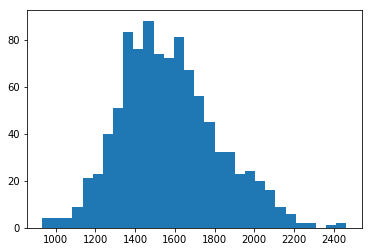

In [59]:
plt.hist(X_pca[:,11].flatten(), bins = 30)

In [105]:
X_test_pca[0:1,:1200].shape

(1, 12)

In [106]:
# Takes a PCA vector and return top producers
top_producers = y_columns[np.argsort(np.vstack(knn.predict_proba(X_test_pca[0:1,:1200]))[:,1])[::-1]]
top_producers

array(['Rick Rubin', 'Paul Epworth', 'Dr. Dre', 'RZA', 'George Martin',
       'Brian Eno', 'Stock Aitken Waterman', 'Roy Thomas Baker',
       'Pete Rock', 'Kanye West'], dtype=object)

In [30]:
# Takes a PCA vector and returns top songs

distances, indices = knn.kneighbors(np.array([[50,50,50,50,50,50,50,50,50,50,50,50]]))
song_df.loc[indices.flatten().tolist()[:5]]

,track,artist,album,mfcc_highpass,genre,producer
534,Staying Fat,Bloc Party,Bloc Party,"[[-44.57645748041316, -52.77683181545641, -73....",pop,Paul Epworth
176,Hell Yea,Obie Trice,Bottoms Up,"[[10.34048419474026, -12.670717682660396, -98....",hip hop,Dr. Dre
122,Can't C Me,2Pac,All Eyez on Me,"[[10.375651403535834, -5.4824673038451905, -92...",hip hop,Dr. Dre
170,Secrets,Obie Trice,Bottoms Up,"[[33.05360338182072, 7.774573215040971, -102.4...",hip hop,Dr. Dre
582,Darkest Place,Plan B,The Defamation of Strickland Banks,"[[-48.682799772834414, -63.59993311991465, -11...",None,Paul Epworth


In [35]:
X_pca.std()

2049.18747870678

In [166]:
artist = None
track = None

In [167]:
song_df[((song_df['artist']==artist) if artist else 1) 
        & (song_df['track']==track)]

,track,artist,album,mfcc_highpass,genre,producer


In [103]:
from sklearn.pipeline import Pipeline

In [89]:
# Write a function that takes a track and artist and returns list of 5 producers and dataframe of 5 (track, artist, album, producer) entries

def query_knn(song_df, ss, knn, y_columns, track, artist=None, album=None):
    query_df = song_df[
                      (song_df['track']==track) &
                      (song_df['artist']==artist if artist else 1) &
                      (song_df['album']==album if album else 1)
                     ]
    audio_data = query_df.iloc[0]['mfcc_highpass']
    flat_audio_data = np.array(audio_data)[:,:1200].flatten().reshape(1,-1)
    print(flat_audio_data.shape)
    X_query_pca = pca.transform(ss.transform(flat_audio_data))
    print(X_query_pca)
    top_producers = y_columns[np.argsort(np.vstack(knn.predict_proba(X_query_pca))[:,1])[::-1]]

    distances, indices = knn.kneighbors(X_query_pca)
    print(indices)
    top_songs = song_df.loc[indices.flatten().tolist()[:5]][['track','artist','album','producer']]
    top_songs['distance'] = distances.flatten()[:5]
    return top_producers, top_songs

In [93]:
top_producers, top_songs = query_knn(song_df, ss, knn, y_columns, track='Hymn')
top_producers

(1, 24000)
[[  8.03360782   9.42277472  14.96685391  19.18657558 -42.51323646
    7.09033844 -11.39860995   1.52157473 -13.88262467 -22.01063886
  -22.68022351  -6.48921458]]
[[ 12 481 546  26 479 486 459 666 966 323 508 482  17 782 681 680 318 158
  544 501  29 340 619 593 426 702 435 502   7 487]]


array(['Stock Aitken Waterman', 'Paul Epworth', 'George Martin',
       'Pete Rock', 'Brian Eno', 'Kanye West', 'Roy Thomas Baker',
       'Dr. Dre', 'Rick Rubin', 'RZA'], dtype=object)

In [94]:
top_songs

,track,artist,album,producer,distance
12,Hymn,Ultravox,Quartet,George Martin,1.476610e-13
481,Boom Boom Satellite,Sigue Sigue Sputnik,Dress for Excess,Stock Aitken Waterman,4.461858e+01
546,Ghost,Lianne La Havas,Blood,Paul Epworth,5.034530e+01
26,Something Tells Me (Something's Gonna Happen T...,Cilla Black,Cilla Black singles chronology,George Martin,5.050622e+01
479,Who Could Ask for Anything More?,Boy Krazy,Boy Krazy,Stock Aitken Waterman,5.558387e+01


In [92]:
song_df.sample(20)

,track,artist,album,mfcc_highpass,genre,producer
811,Here Comes the Gravediggaz,Gravediggaz,6 Feet Deep,"[[-325.46069115854124, -314.2303934540428, -34...",hip hop,RZA
51,You've Got To Hide Your Love Away,the Beatles,20 Greatest Hits,"[[-282.2831612029979, -292.63676738656136, -33...",rock,George Martin
322,Strangers When We Meet,David Bowie,1. Outside,"[[-70.91511059540349, -86.2553956957963, -145....",rock,Brian Eno
761,All I'm Giving (feat. David Dam) [Radio Edit],Chris Brown,Before the Party,"[[-19.864762071374646, -29.131329746403775, -8...",None,Kanye West
75,To Each His Own - Live Version,America,Live,"[[-201.4959375857263, -197.5275249796764, -206...",country,George Martin
316,Life During Wartime - 2005 Remastered Version,Talking Heads,Fear of Music,"[[-168.19140377221478, -184.4793908749072, -24...",rock,Brian Eno
632,Genesis,De La Soul,And the Anonymous Nobody...,"[[-222.71756596099848, -237.5803140511843, -28...",hip hop,Pete Rock
203,Aeroplane,Red Hot Chili Peppers,One Hot Minute,"[[-21.13435077757185, -35.449959302930075, -10...",rock,Rick Rubin
868,Freakshow,Method Man & Redman,Blackout!,"[[-58.561402151842856, -78.01425508703323, -14...",hip hop,RZA
103,How We Do,The Game featuring 50 Cent,The Documentary,"[[-285.48173165338903, -300.4269797071679, -36...",None,Dr. Dre


In [109]:
pipeline = Pipeline(steps=[('ss',ss),
                     ('pca',pca),
                     ('knn',knn.predict_proba)])

TypeError: Last step of Pipeline should implement fit. '<bound method KNeighborsClassifier.predict_proba of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=30, p=2,
           weights='uniform')>' (type <class 'method'>) doesn't

In [114]:
pipeline = Pipeline([('ss',StandardScaler()),
                     ('pca',PCA(n_components=12))
                    ]
                   )

In [115]:
pipeline.fit_transform(X)

array([[ -5.92556759,   9.26195634, -38.40809255, ...,  16.4970865 ,
         -5.10018973, -21.78687732],
       [ 42.28521514,  22.35556663, -26.77753632, ...,  32.42379448,
         -1.69549867, -14.76777689],
       [ 14.22671922,  15.77747332,  -9.53423042, ...,  -6.48067064,
        -18.02432766,   5.41703778],
       ...,
       [-12.78340473,   1.73643461, -28.38017091, ..., -20.60415641,
          3.13398035,  -9.29451311],
       [ 44.70922682, -11.88054257, -59.27307355, ..., -14.49855103,
         -6.23283598,   5.84981373],
       [-20.07065575,   2.42453256, -25.94165586, ...,  -6.2041021 ,
          1.09094184,  -9.27239941]])

In [117]:
import src.knn_modeling as km

In [151]:
reload(km)

<module 'src.knn_modeling' from '/Users/Maxwell/galvanize/production-value/src/knn_modeling.py'>

In [152]:
pv = km.ProductionValue(collection = mfcc_collection, sp = sp)

In [153]:
pv.fit_knn('mfcc_highpass')

In [154]:
pv.accuracy

0.5118924508790073

In [155]:
pv.song_df.head()

,track,artist,album,mfcc_highpass,genre,producer
0,Act Naturally,Buck Owens and the Buckaroos,The Best of Buck Owens,"[[-106.0409148180113, -114.71286150048788, -15...",country,George Martin
1,Alfie,Cilla Black,Cilla Black singles chronology,"[[-115.42859278964515, -133.7129072512278, -20...",pop,George Martin
2,Amber Cascades,America,Hideaway,"[[-132.7895650459967, -149.0103345463059, -205...",country,George Martin
3,Anyone Who Had a Heart,Dionne Warwick,Anyone Who Had a Heart,"[[-417.5704948136371, -400.7918664259179, -375...",soul,George Martin
4,Baby It's You,The Shirelles,Baby It's You,"[[-199.51104878028514, -215.14526944983157, -2...",soul,George Martin


In [157]:
top_producers, top_songs = pv.query('Alfie')

In [158]:
top_producers

array(['George Martin', 'Brian Eno', 'Pete Rock', 'Dr. Dre',
       'Roy Thomas Baker', 'Paul Epworth', 'Kanye West',
       'Stock Aitken Waterman', 'Rick Rubin', 'RZA'], dtype=object)